In [1]:
!nvidia-smi

Wed Feb 16 21:16:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import zipfile
zipfile.ZipFile("/content/drive/MyDrive/Newcastle University/Deep Learning/Data/birds.zip", 'r').extractall('birds/')

In [3]:
import os
import cv2
import math
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [4]:
seed = 7
np.random.seed(seed)

In [5]:
train_path = "birds/train"
valid_path = "birds/valid"
test_path = "birds/test"

In [6]:
# Function used to plot the curves for loss and accuracy:
def plot_curves(history):

  # Plotting the loss curve:
  plt.subplot(211)
  plt.title('Cross Entropy')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  # Plotting the training loss (blue):
  plt.plot(history.history['loss'], color='blue', label='train')
  # Plotting the test loss (red):
  plt.plot(history.history['val_loss'], color='red', label='test')
  # Legend for the plot:
  plt.legend(['train', 'test'], loc='upper left')

  # Plotting the accuracy curve:
  plt.subplot(212)
  plt.title('Classification Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  # Plotting the training accuracy (blue):
  plt.plot(history.history['accuracy'], color='blue', label='train')
  # Plotting the test accuracy (red):
  plt.plot(history.history['val_accuracy'], color='red', label='test')
  # Legend for the plot:
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplots_adjust(top=3)
  plt.show()

print('Done!')

Done!


In [7]:
# class names list
class_names = ['AFRICAN CROWNED CRANE', 'AFRICAN FIREFINCH', 'ALBATROSS', 'ALEXANDRINE PARAKEET', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'ANHINGA', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ARARIPE MANAKIN', 'ASIAN CRESTED IBIS', 'BALD EAGLE', 'BALI STARLING', 'BALTIMORE ORIOLE', 'BANANAQUIT', 'BANDED BROADBILL', 'BAR-TAILED GODWIT', 'BARN OWL', 'BARN SWALLOW', 'BARRED PUFFBIRD', 'BAY-BREASTED WARBLER', 'BEARDED BARBET', 'BELTED KINGFISHER', 'BIRD OF PARADISE', 'BLACK FRANCOLIN', 'BLACK SKIMMER', 'BLACK SWAN', 'BLACK THROATED WARBLER', 'BLACK VULTURE', 'BLACK-CAPPED CHICKADEE', 'BLACK-NECKED GREBE', 'BLACK-THROATED SPARROW', 'BLACKBURNIAM WARBLER', 'BLUE GROUSE', 'BLUE HERON', 'BOBOLINK', 'BROWN NOODY', 'BROWN THRASHER', 'CACTUS WREN', 'CALIFORNIA CONDOR', 'CALIFORNIA GULL', 'CALIFORNIA QUAIL', 'CANARY', 'CAPE MAY WARBLER', 'CAPUCHINBIRD', 'CARMINE BEE-EATER', 'CASPIAN TERN', 'CASSOWARY', 'CHARA DE COLLAR', 'CHIPPING SPARROW', 'CHUKAR PARTRIDGE', 'CINNAMON TEAL', 'COCK OF THE  ROCK', 'COCKATOO', 'COMMON FIRECREST', 'COMMON GRACKLE', 'COMMON HOUSE MARTIN', 'COMMON LOON', 'COMMON POORWILL', 'COMMON STARLING', 'COUCHS KINGBIRD', 'CRESTED AUKLET', 'CRESTED CARACARA', 'CRESTED NUTHATCH', 'CROW', 'CROWNED PIGEON', 'CUBAN TODY', 'CURL CRESTED ARACURI', 'D-ARNAUDS BARBET', 'DARK EYED JUNCO', 'DOWNY WOODPECKER', 'EASTERN BLUEBIRD', 'EASTERN MEADOWLARK', 'EASTERN ROSELLA', 'EASTERN TOWEE', 'ELEGANT TROGON', 'ELLIOTS  PHEASANT', 'EMPEROR PENGUIN', 'EMU', 'EURASIAN GOLDEN ORIOLE', 'EURASIAN MAGPIE', 'EVENING GROSBEAK', 'FIRE TAILLED MYZORNIS', 'FLAME TANAGER', 'FLAMINGO', 'FRIGATE', 'GAMBELS QUAIL', 'GILA WOODPECKER', 'GILDED FLICKER', 'GLOSSY IBIS', 'GO AWAY BIRD', 'GOLD WING WARBLER', 'GOLDEN CHEEKED WARBLER', 'GOLDEN CHLOROPHONIA', 'GOLDEN EAGLE', 'GOLDEN PHEASANT', 'GOLDEN PIPIT', 'GOULDIAN FINCH', 'GRAY CATBIRD', 'GRAY PARTRIDGE', 'GREAT POTOO', 'GREATOR SAGE GROUSE', 'GREEN JAY', 'GREY PLOVER', 'GUINEA TURACO', 'GUINEAFOWL', 'GYRFALCON', 'HARPY EAGLE', 'HAWAIIAN GOOSE', 'HELMET VANGA', 'HOATZIN', 'HOODED MERGANSER', 'HOOPOES', 'HORNBILL', 'HORNED GUAN', 'HORNED SUNGEM', 'HOUSE FINCH', 'HOUSE SPARROW', 'IMPERIAL SHAQ', 'INCA TERN', 'INDIAN BUSTARD', 'INDIAN PITTA', 'INDIGO BUNTING', 'JABIRU', 'JAVA SPARROW', 'JAVAN MAGPIE', 'KAKAPO', 'KILLDEAR', 'KING VULTURE', 'KIWI', 'KOOKABURRA', 'LARK BUNTING', 'LEARS MACAW', 'LILAC ROLLER', 'LONG-EARED OWL', 'MALABAR HORNBILL', 'MALACHITE KINGFISHER', 'MALEO', 'MALLARD DUCK', 'MANDRIN DUCK', 'MARABOU STORK', 'MASKED BOOBY', 'MASKED LAPWING', 'MIKADO  PHEASANT', 'MOURNING DOVE', 'MYNA', 'NICOBAR PIGEON', 'NORTHERN BALD IBIS', 'NORTHERN CARDINAL', 'NORTHERN FLICKER', 'NORTHERN GANNET', 'NORTHERN GOSHAWK', 'NORTHERN JACANA', 'NORTHERN MOCKINGBIRD', 'NORTHERN PARULA', 'NORTHERN RED BISHOP', 'OCELLATED TURKEY', 'OKINAWA RAIL', 'OSPREY', 'OSTRICH', 'OYSTER CATCHER', 'PAINTED BUNTIG', 'PALILA', 'PARADISE TANAGER', 'PARUS MAJOR', 'PEACOCK', 'PELICAN', 'PEREGRINE FALCON', 'PHILIPPINE EAGLE', 'PINK ROBIN', 'PUFFIN', 'PURPLE FINCH', 'PURPLE GALLINULE', 'PURPLE MARTIN', 'PURPLE SWAMPHEN', 'QUETZAL', 'RAINBOW LORIKEET', 'RAZORBILL', 'RED BEARDED BEE EATER', 'RED BELLIED PITTA', 'RED FACED CORMORANT', 'RED FACED WARBLER', 'RED HEADED DUCK', 'RED HEADED WOODPECKER', 'RED HONEY CREEPER', 'RED WINGED BLACKBIRD', 'RED WISKERED BULBUL', 'RING-NECKED PHEASANT', 'ROADRUNNER', 'ROBIN', 'ROCK DOVE', 'ROSY FACED LOVEBIRD', 'ROUGH LEG BUZZARD', 'RUBY THROATED HUMMINGBIRD', 'RUFOUS KINGFISHER', 'RUFUOS MOTMOT', 'SAMATRAN THRUSH', 'SAND MARTIN', 'SCARLET IBIS', 'SCARLET MACAW', 'SHOEBILL', 'SHORT BILLED DOWITCHER', 'SMITHS LONGSPUR', 'SNOWY EGRET', 'SNOWY OWL', 'SORA', 'SPANGLED COTINGA', 'SPLENDID WREN', 'SPOON BILED SANDPIPER', 'SPOONBILL', 'SRI LANKA BLUE MAGPIE', 'STEAMER DUCK', 'STORK BILLED KINGFISHER', 'STRAWBERRY FINCH', 'STRIPPED SWALLOW', 'SUPERB STARLING', 'SWINHOES PHEASANT', 'TAIWAN MAGPIE', 'TAKAHE', 'TASMANIAN HEN', 'TEAL DUCK', 'TIT MOUSE', 'TOUCHAN', 'TOWNSENDS WARBLER', 'TREE SWALLOW', 'TRUMPTER SWAN', 'TURKEY VULTURE', 'TURQUOISE MOTMOT', 'UMBRELLA BIRD', 'VARIED THRUSH', 'VENEZUELIAN TROUPIAL', 'VERMILION FLYCATHER', 'VIOLET GREEN SWALLOW', 'VULTURINE GUINEAFOWL', 'WATTLED CURASSOW', 'WHIMBREL', 'WHITE CHEEKED TURACO', 'WHITE NECKED RAVEN', 'WHITE TAILED TROPIC', 'WILD TURKEY', 'WILSONS BIRD OF PARADISE', 'WOOD DUCK', 'YELLOW BELLIED FLOWERPECKER', 'YELLOW CACIQUE', 'YELLOW HEADED BLACKBIRD']

In [8]:
#defining train, valid and test generators
print("training data")
train_gen = keras.preprocessing.image_dataset_from_directory(
    directory = train_path,
    label_mode = 'categorical',
    class_names=class_names,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=seed,
)

print("\nvalidation data")
valid_gen = keras.preprocessing.image_dataset_from_directory(
    directory = valid_path,
    label_mode = 'categorical',
    class_names=class_names,
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=seed,
)

print("\ntesting data")
test_gen = keras.preprocessing.image_dataset_from_directory(
    directory = test_path,
    label_mode = 'categorical',
    class_names=class_names,
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
    seed=seed,
)

training data
Found 35215 files belonging to 250 classes.

validation data
Found 1250 files belonging to 250 classes.

testing data
Found 1250 files belonging to 250 classes.


# Visualize the data
Here are the first 9 images in the training dataset. As you can see, bird species along with their corresponding (labels).

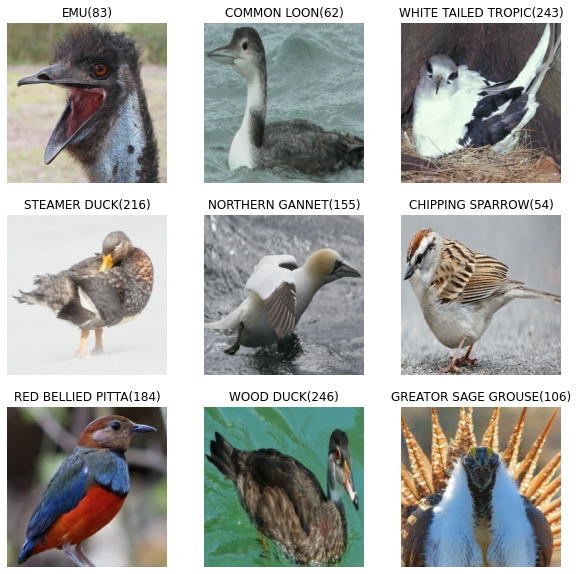

In [9]:
# visualizing the dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_gen.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((class_names[np.argmax(labels[i])] + '(' + str(int(np.argmax(labels[i]))) + ')'))
        plt.axis("off")

# Building the model
---
## ResNet50V2

### ResNet50V2 - with GAP

In [18]:
# Function to build the model
def build_model():

    base_model = keras.applications.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    # Freezing the base model
    base_model.trainable = False
    #base_model.summary()

    inputs = keras.Input(shape=(224, 224, 3))
    # Pre-trained ResNetV2 input preprocessing
    scale_layer = keras.applications.inception_resnet_v2.preprocess_input(inputs)
    
    x = base_model(scale_layer, training=False)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(250, activation='softmax')(x)
    model = keras.Model(inputs, outputs)

    return model

print('Done!')

Done!


In [19]:
# Model initialization
model_gap = build_model()
model_gap.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                           

#### Setting static optimizers

In [20]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(0.002)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [21]:
# Compiling the model
model_gap.compile(loss='categorical_crossentropy', optimizer=adam ,metrics=['accuracy'])

In [22]:
# defining model checkpoints for weight saving
cp = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Newcastle University/Deep Learning/Models/InResV2_gap_static_adam_run01.h5', verbose = 1, save_best_only = True, monitor='val_accuracy')

#### Model Training

In [23]:
epochs = 10
history = model_gap.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=cp)

Epoch 1/10
1101/1101 [==============================] - ETA: 0s - loss: 2.2924 - accuracy: 0.4424
Epoch 1: val_accuracy improved from -inf to 0.72560, saving model to /content/drive/MyDrive/Newcastle University/Deep Learning/Models/InResV2_gap_static_adam_run01.h5
1101/1101 [==============================] - 150s 127ms/step - loss: 2.2924 - accuracy: 0.4424 - val_loss: 0.9879 - val_accuracy: 0.7256
Epoch 2/10
1101/1101 [==============================] - ETA: 0s - loss: 1.2261 - accuracy: 0.6484
Epoch 2: val_accuracy improved from 0.72560 to 0.80000, saving model to /content/drive/MyDrive/Newcastle University/Deep Learning/Models/InResV2_gap_static_adam_run01.h5
1101/1101 [==============================] - 138s 125ms/step - loss: 1.2261 - accuracy: 0.6484 - val_loss: 0.7163 - val_accuracy: 0.8000
Epoch 3/10
1101/1101 [==============================] - ETA: 0s - loss: 0.9824 - accuracy: 0.7122
Epoch 3: val_accuracy improved from 0.80000 to 0.84400, saving model to /content/drive/MyDrive/

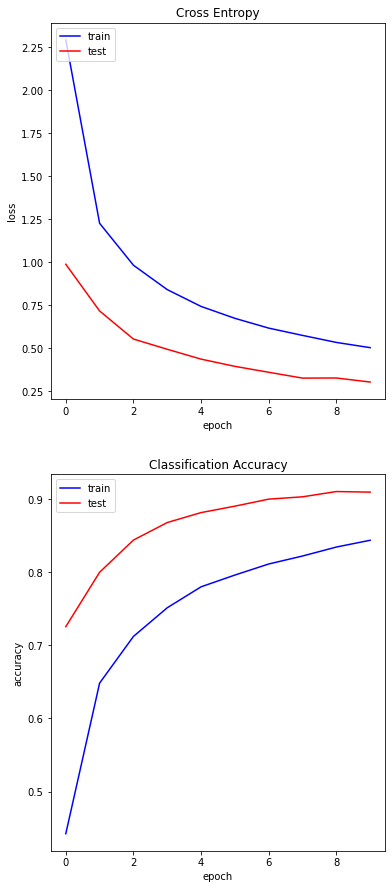

In [24]:
plot_curves(history)

In [25]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model_gap.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [26]:
accuracy_score(labels, predictions)

0.9256

In [27]:
precision_score(labels, predictions, average='weighted')

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.9416467532467534

In [28]:
recall_score(labels, predictions, average='weighted')

0.9256

In [29]:
f1_score(labels, predictions, average='weighted')

0.9223653124653125

In [30]:
cm = confusion_matrix(labels, predictions)
cm

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 4, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 3]])

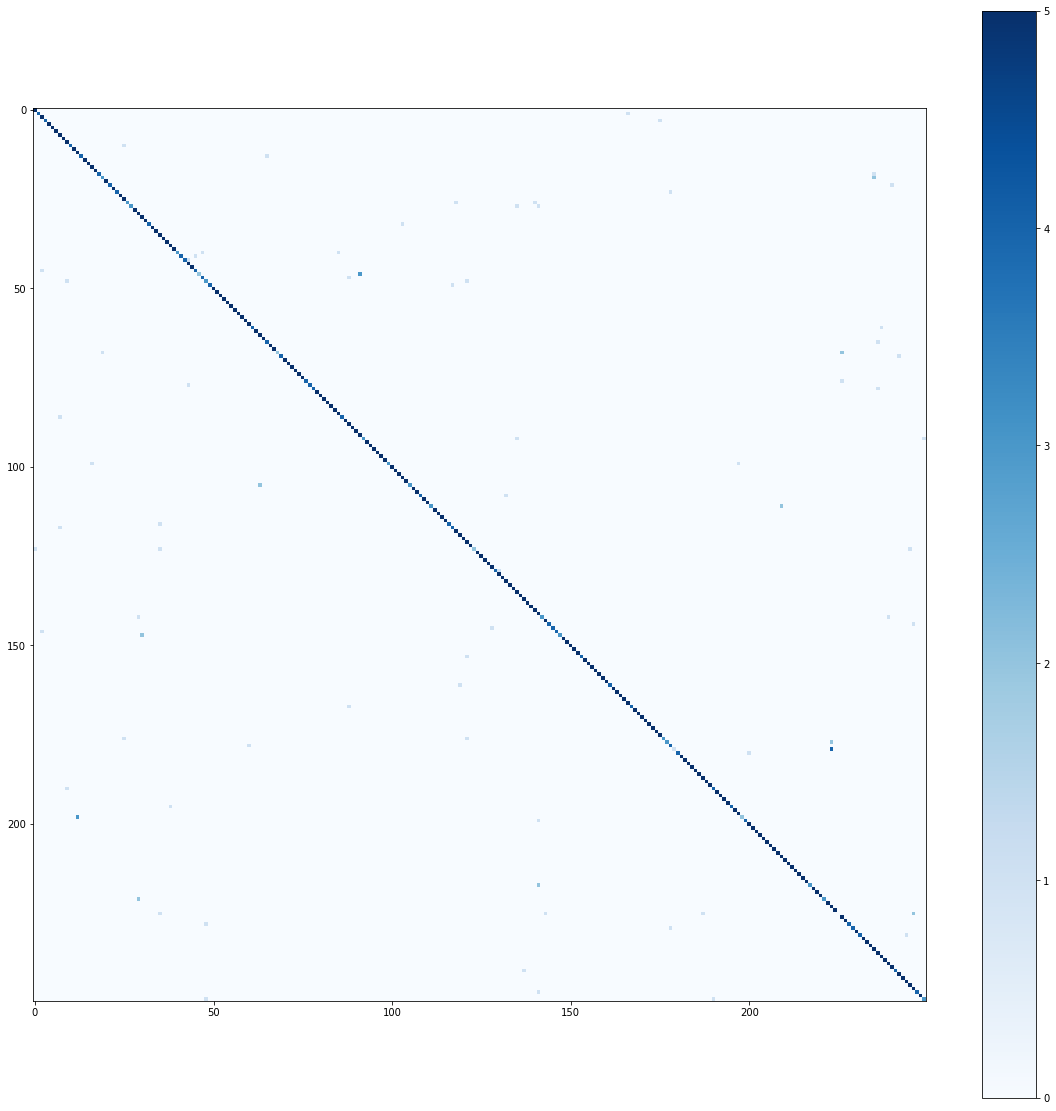

In [31]:
df_cm = pd.DataFrame(cm, index = [i for i in range(250)],
                  columns = [i for i in range(250)])
plt.figure(figsize = (20,20))
plt.imshow(df_cm, cmap='Blues')
plt.colorbar(orientation='vertical', aspect=20)

#### Fine-tuning the model

In [32]:
sgd = keras.optimizers.SGD(learning_rate=0.002)
adam = keras.optimizers.Adam(learning_rate=0.00002)
nadam = keras.optimizers.Nadam(learning_rate=0.002)

In [33]:
model_gap.trainable = True
model_gap.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                           

In [34]:
# Compiling the model
model_gap.compile(loss='categorical_crossentropy', optimizer=adam ,metrics=['accuracy'])

In [35]:
# defining model checkpoints for weight saving
cp = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Newcastle University/Deep Learning/Models/ResNetV2_gap_static_adam_ft_run01.h5', verbose = 1, save_best_only = True, monitor='val_accuracy')

#### Model Training

In [36]:
epochs = 10
history = model_gap.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=cp)

Epoch 1/10
1101/1101 [==============================] - ETA: 0s - loss: 0.3447 - accuracy: 0.8955
Epoch 1: val_accuracy improved from -inf to 0.95120, saving model to /content/drive/MyDrive/Newcastle University/Deep Learning/Models/ResNetV2_gap_static_adam_ft_run01.h5
1101/1101 [==============================] - 429s 373ms/step - loss: 0.3447 - accuracy: 0.8955 - val_loss: 0.1742 - val_accuracy: 0.9512
Epoch 2/10
1101/1101 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9238
Epoch 2: val_accuracy improved from 0.95120 to 0.95680, saving model to /content/drive/MyDrive/Newcastle University/Deep Learning/Models/ResNetV2_gap_static_adam_ft_run01.h5
1101/1101 [==============================] - 414s 376ms/step - loss: 0.2497 - accuracy: 0.9238 - val_loss: 0.1465 - val_accuracy: 0.9568
Epoch 3/10
1101/1101 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9405
Epoch 3: val_accuracy improved from 0.95680 to 0.96080, saving model to /content/drive/

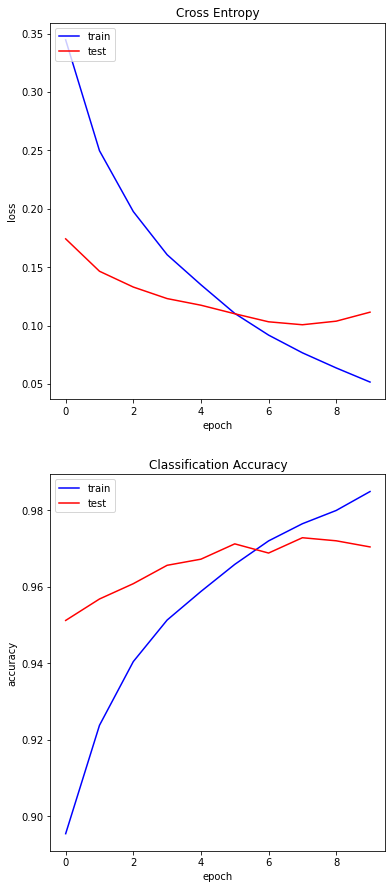

In [37]:
plot_curves(history)

In [38]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model_gap.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [ ]:
accuracy_score(labels, predictions)

In [40]:
precision_score(labels, predictions, average='weighted')

0.9835809523809523

In [41]:
recall_score(labels, predictions, average='weighted')

0.98

In [42]:
f1_score(labels, predictions, average='weighted')

0.9789272727272728

In [43]:
cm = confusion_matrix(labels, predictions)
cm

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 4]])

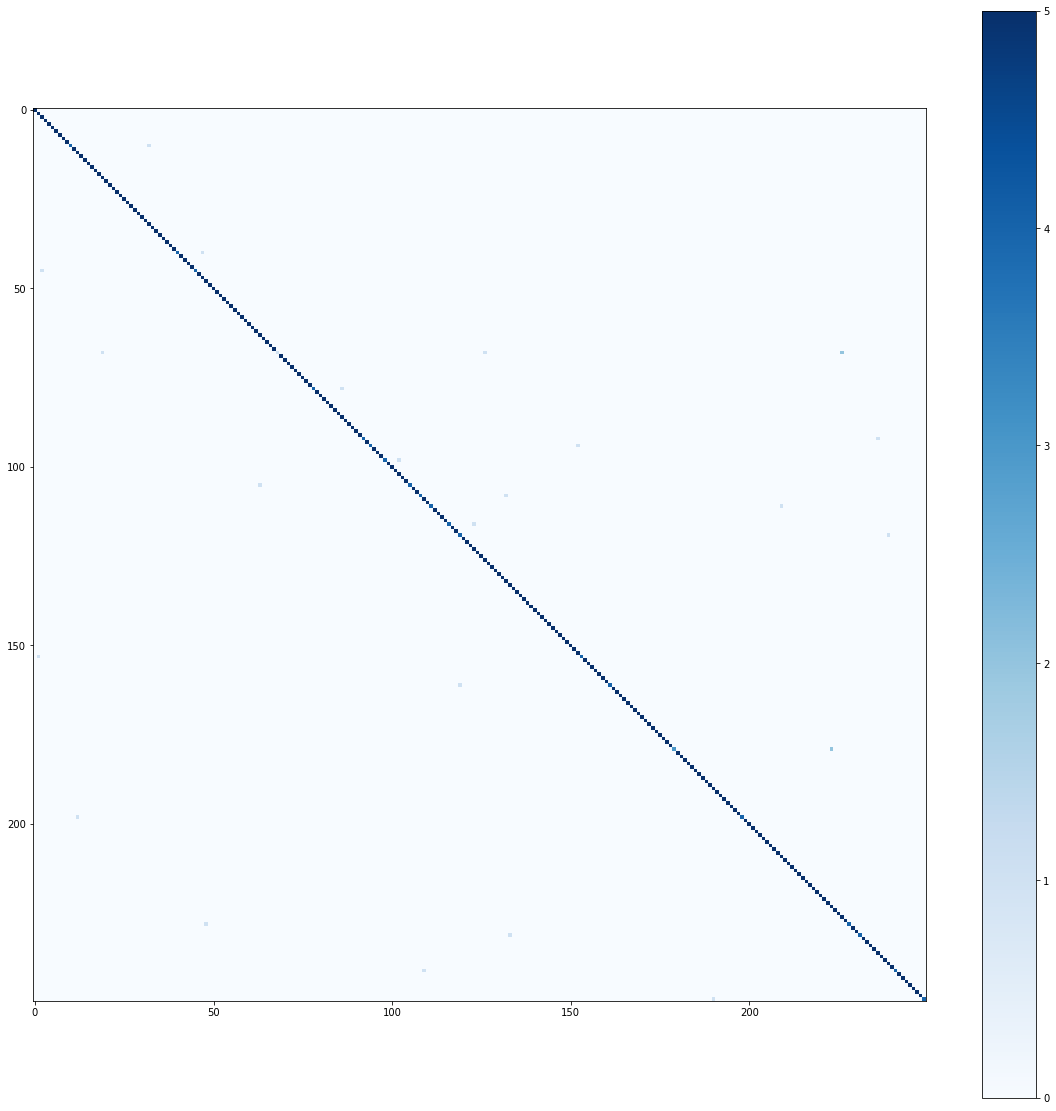

In [44]:
df_cm = pd.DataFrame(cm, index = [i for i in range(250)],
                  columns = [i for i in range(250)])
plt.figure(figsize = (20,16))
plt.imshow(df_cm, cmap='Blues')
plt.colorbar(orientation='vertical', aspect=50)

### Evaluating the model with saved weights

In [45]:
model_gap.load_weights('/content/drive/MyDrive/Newcastle University/Deep Learning/Models/ResNetV2_gap_static_adam_ft_run01.h5')

In [46]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_gen:
  predictions = np.concatenate([predictions, np.argmax(model_gap.predict(x), axis=-1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

In [47]:
accuracy_score(labels, predictions)

0.9832

In [48]:
precision_score(labels, predictions, average='weighted')

0.9860571428571427

In [49]:
recall_score(labels, predictions, average='weighted')

0.9832

In [50]:
f1_score(labels, predictions, average='weighted')

0.9822101010101011

In [51]:
cm = confusion_matrix(labels, predictions)
cm

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0],
       [0, 0, 5, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 5, 0],
       [0, 0, 0, ..., 0, 0, 4]])

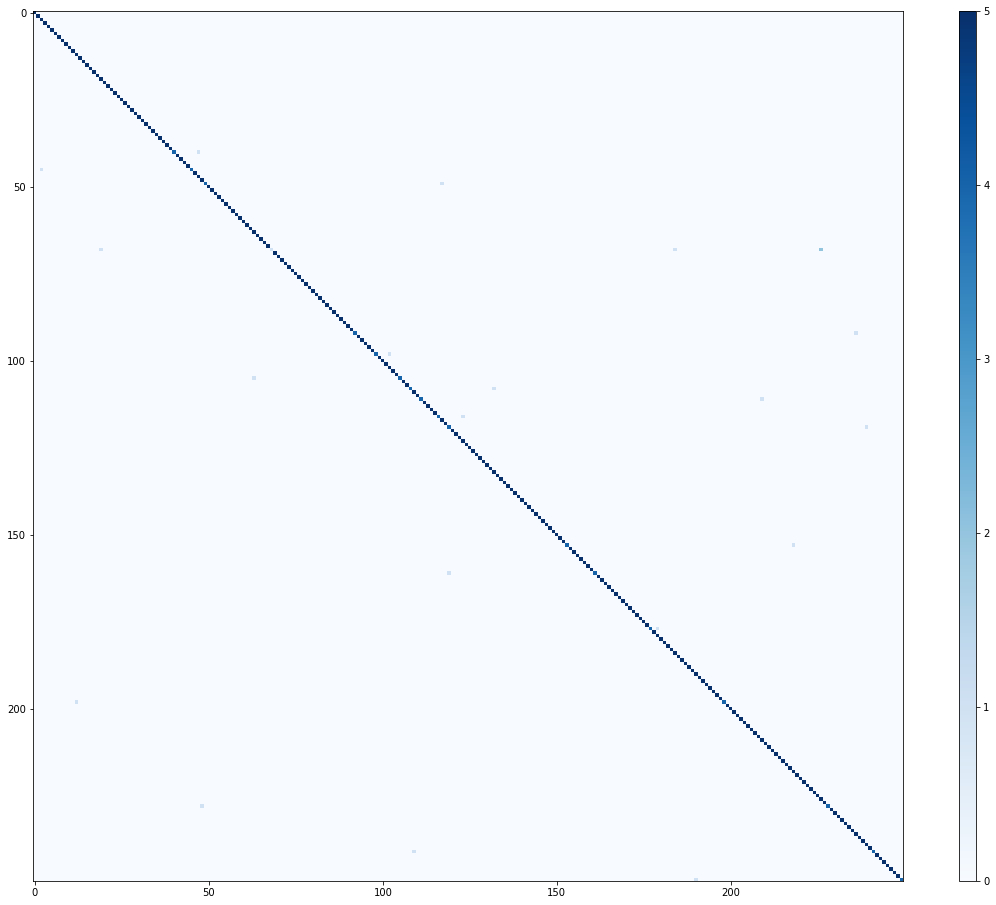

In [55]:
df_cm = pd.DataFrame(cm, index = [i for i in range(250)],
                  columns = [i for i in range(250)])
plt.figure(figsize = (20,16))
plt.imshow(df_cm, cmap='Blues')
plt.colorbar(orientation='vertical', aspect=50)